In [ ]:
  !pip install opencv-python-headless


In [27]:
  from google.colab import drive
  drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
  import os
  import numpy as np
  import tensorflow as tf
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed
  from tensorflow.keras.callbacks import ModelCheckpoint
  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  # Set the path for the training data
  train_data_dir = '/content/drive/My Drive/Colab Notebooks/alphabets/asl_alphabet_train'

  # Data preprocessing
  datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

  train_generator = datagen.flow_from_directory(
      train_data_dir,
      target_size=(224, 224),
      batch_size=32,
      class_mode='categorical',
      subset='training',
      color_mode='rgb')

  validation_generator = datagen.flow_from_directory(
      train_data_dir,
      target_size=(224, 224),
      batch_size=32,
      class_mode='categorical',
      subset='validation',
      color_mode='rgb')



  # Define the CNN model
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
  model.add(MaxPooling2D(2, 2))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(29, activation='softmax'))  # 26 letters + space + nothing + del

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


  # Checkpoint callback
  checkpoint_path = "/content/drive/My Drive/Colab Notebooks/alphabets/checkpoints/cp-{epoch:04d}.ckpt"
  cp_callback = ModelCheckpoint(
      filepath=checkpoint_path,
      verbose=1,
      save_weights_only=True,
      save_freq=200*32)  # 200 steps * batch_size

  # Train the model
  history = model.fit(
      train_generator,
      steps_per_epoch=200,  # Adjust based on your dataset
      epochs=5,  # Adjust based on your requirement
      validation_data=validation_generator,
      validation_steps=50,  # Adjust based on your dataset
      callbacks=[cp_callback],
      use_multiprocessing=True,  # Faster training without GPU
      workers=4)  # Adjust based on your system

  # Save the final model
  model.save('/content/drive/My Drive/Colab Notebooks/alphabets/saved_model.h5')


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Epoch 1/5
200/200 [==============================] - 834s 4s/step - loss: 3.1363 - accuracy: 0.1078 - val_loss: 2.7842 - val_accuracy: 0.1744
Epoch 2/5
200/200 [==============================] - 816s 4s/step - loss: 1.7111 - accuracy: 0.4791 - val_loss: 2.0524 - val_accuracy: 0.3762
Epoch 3/5
200/200 [==============================] - 824s 4s/step - loss: 0.9587 - accuracy: 0.6947 - val_loss: 1.7392 - val_accuracy: 0.4369
Epoch 4/5
200/200 [==============================] - 817s 4s/step - loss: 0.6324 - accuracy: 0.7981 - val_loss: 1.5076 - val_accuracy: 0.4725
Epoch 5/5
200/200 [==============================] - 829s 4s/step - loss: 0.4674 - accuracy: 0.8486 - val_loss: 1.4384 - val_accuracy: 0.5475


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
  from tensorflow.keras.utils import Sequence
  import numpy as np
  import os
  import random
  #from tensorflow.keras.preprocessing.image import load_img, img_to_arra
  from tensorflow.keras.utils import Sequence
  from tensorflow.keras.preprocessing.image import load_img, img_to_array
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
  from tensorflow.keras.callbacks import ModelCheckpoint


  class ImageSequenceGenerator(Sequence):
    def __init__(self, directory, sequence_length=5, batch_size=32, target_size=(224, 224), class_indices=None, split='train', validation_split=0.2):
        self.directory = directory
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.target_size = target_size
        if class_indices is None:
            self.class_indices = self._get_class_indices()
        else:
            self.class_indices = class_indices
        self.classes = sorted(os.listdir(directory))
        self.split = split
        self.validation_split = validation_split
        self.file_paths = self._load_file_paths()

    def _get_class_indices(self):
        class_names = sorted(os.listdir(self.directory))
        return {class_name: index for index, class_name in enumerate(class_names)}


    def __len__(self):
          return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.file_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.zeros((len(batch_paths), self.sequence_length, *self.target_size, 3), dtype=np.float32)
        batch_y = np.zeros((len(batch_paths), len(self.classes)), dtype=np.float32)

        for i, paths in enumerate(batch_paths):
            for j, path in enumerate(paths):
                img = load_img(path, target_size=self.target_size)
                img = img_to_array(img)
                img /= 255.0
                batch_x[i, j] = img
            label = self._get_class_label(paths[0])
            batch_y[i, label] = 1

        return batch_x, batch_y

    def _load_file_paths(self):
        file_paths = []
        for cls in self.classes:
            class_path = os.path.join(self.directory, cls)
            class_files = [os.path.join(class_path, f) for f in os.listdir(class_path)]
            if self.split == 'train':
                class_files = class_files[:int(len(class_files) * (1 - self.validation_split))]
            else:  # split == 'validation'
                class_files = class_files[int(len(class_files) * (1 - self.validation_split)):]
            class_sequences = [random.sample(class_files, self.sequence_length) for _ in range(len(class_files) // self.sequence_length)]
            file_paths.extend(class_sequences)
        random.shuffle(file_paths)
        return file_paths

    def _get_class_label(self, file_path):
        class_name = os.path.basename(os.path.dirname(file_path))
        return self.class_indices[class_name]

  # Prepare data generators
  train_data_dir = '/content/drive/My Drive/Colab Notebooks/alphabets/asl_alphabet_train'
  #train_datagen = ImageSequenceGenerator(train_data_dir, class_indices=train_generator.class_indices)


In [18]:
  # Initialize the training data generator
  train_generator = ImageSequenceGenerator(train_data_dir, split='train', validation_split=0.2)

  # Initialize the validation data generator
  validation_generator = ImageSequenceGenerator(train_data_dir, split='validation', validation_split=0.2)


  # Define the CNN+LSTM model
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(5, 224, 224, 3)))
  model.add(TimeDistributed(MaxPooling2D(2, 2)))
  model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(2, 2)))
  model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(2, 2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(29, activation='softmax'))  # 26 letters + space + nothing + del

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Checkpoint callback
  checkpoint_path = "/content/drive/My Drive/Colab Notebooks/alphabets/checkpoints/cp-{epoch:04d}.ckpt"
  cp_callback = ModelCheckpoint(
      filepath=checkpoint_path,
      verbose=1,
      save_weights_only=True,
      save_freq=200*32)  # 200 steps * batch_size

 # Train the model
  history = model.fit(
    train_generator,
    steps_per_epoch=200,  # Adjust based on your dataset
    epochs=5,  # Adjust based on your requirement
    validation_data=validation_generator,  # Validation generator
    validation_steps=50,  # Adjust based on your dataset
    callbacks=[cp_callback],
    use_multiprocessing=True,  # Faster training without GPU
    workers=4)  # Adjust based on your system

  # Save the final model
  model.save('/content/drive/My Drive/Colab Notebooks/alphabets/saved_model.h5')


Epoch 1/5
200/200 [==============================] - 4130s 21s/step - loss: 2.6675 - accuracy: 0.2848 - val_loss: 2.2462 - val_accuracy: 0.4062
Epoch 2/5
200/200 [==============================] - 4160s 21s/step - loss: 0.5369 - accuracy: 0.9287 - val_loss: 1.8116 - val_accuracy: 0.5362
Epoch 3/5
200/200 [==============================] - 4082s 20s/step - loss: 0.1110 - accuracy: 0.9939 - val_loss: 1.5590 - val_accuracy: 0.5794
Epoch 4/5
200/200 [==============================] - 4100s 20s/step - loss: 0.0433 - accuracy: 0.9983 - val_loss: 1.3513 - val_accuracy: 0.6231
Epoch 5/5
200/200 [==============================] - 4146s 21s/step - loss: 0.0203 - accuracy: 0.9998 - val_loss: 1.2765 - val_accuracy: 0.6506


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
  from IPython.display import display, Javascript
  from google.colab.output import eval_js
  from base64 import b64decode
  import numpy as np
  from tensorflow.keras.models import load_model
  import cv2
  import io
  import json
  from PIL import Image

  # Load the trained model
  model = load_model('/content/drive/My Drive/Colab Notebooks/alphabets/saved_model.h5')

  # JavaScript to capture a single image
  def take_photo(filename='photo.jpg', quality=0.8):
      js = Javascript('''
          async function takePhoto(quality) {
              const div = document.createElement('div');
              const capture = document.createElement('button');
              capture.textContent = 'Capture';
              div.appendChild(capture);

              const video = document.createElement('video');
              video.style.display = 'block';
              const stream = await navigator.mediaDevices.getUserMedia({video: true});

              document.body.appendChild(div);
              div.appendChild(video);
              video.srcObject = stream;
              await video.play();

              // Resize the output to fit the video element.
              google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

              let dataUrls = [];
              for (let i = 0; i < 5; i++) {
                  await new Promise((resolve) => setTimeout(resolve, 1000)); // wait for 1 second between captures
                  capture.textContent = 'Capturing frame ' + (i + 1);
                  const canvas = document.createElement('canvas');
                  canvas.width = video.videoWidth;
                  canvas.height = video.videoHeight;
                  canvas.getContext('2d').drawImage(video, 0, 0);
                  dataUrls.push(canvas.toDataURL('image/jpeg', quality));
              }

              stream.getVideoTracks()[0].stop();
              div.remove();
              return dataUrls;
          }
      ''')
      display(js)
      data_urls = eval_js('takePhoto({})'.format(quality))
      images = []
      for data_url in data_urls:
          binary = b64decode(data_url.split(',')[1])
          image = np.array(Image.open(io.BytesIO(binary)).convert('RGB'))
          images.append(image)
      return images

  # Function to preprocess the frame for prediction
  def preprocess_frame(frame):
      frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      frame = cv2.resize(frame, (224, 224))
      frame = np.stack((frame,)*3, axis=-1)
      frame = frame / 255.0
      return frame

  # Load label map
  label_map_file = '/content/drive/My Drive/Colab Notebooks/alphabets/model.json'
  with open(label_map_file, 'r') as f:
      label_map = json.load(f)

  # Capture photos
  frames = take_photo()

  # Reverse the label map to map indices to labels
  reversed_label_map = {v: k for k, v in label_map.items()}

  # Process each frame and stack them
  processed_frames = [preprocess_frame(frame) for frame in frames]
  processed_frames = np.array(processed_frames)

  # Ensure the shape is (1, num_frames, height, width, channels)
  processed_frames = np.expand_dims(processed_frames, axis=0)

  # Check the shape of processed_frames
  print(f"Shape of processed_frames: {processed_frames.shape}")

  # Predict the captured image sequence
  prediction = model.predict(processed_frames)
  predicted_class = np.argmax(prediction, axis=1)
  predicted_label = reversed_label_map[predicted_class[0]]

  # Output the prediction
  print(f"Predicted Class: {predicted_class}, Predicted Label: {predicted_label}")



<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 85ms/step
Predicted ASL Letter: L


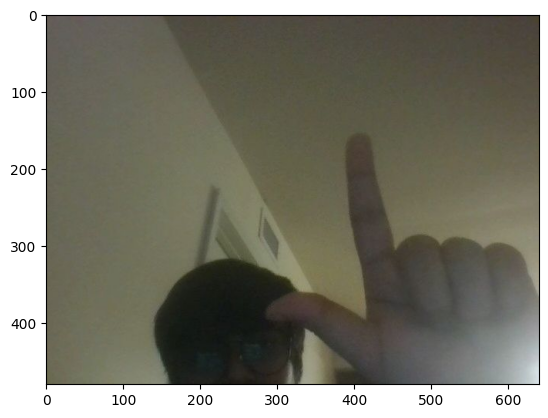

In [45]:
  # Import necessary libraries
  import numpy as np
  import cv2
  from keras.models import model_from_json
  from IPython.display import display, Javascript
  from google.colab.output import eval_js
  from base64 import b64decode
  import io
  from PIL import Image
  from matplotlib import pyplot as plt

  # JavaScript to capture images
  def take_photo(filename='photo.jpg', quality=0.8):
      js = Javascript('''
          async function takePhoto(quality) {
              const div = document.createElement('div');
              const capture = document.createElement('button');
              capture.textContent = 'Capture';
              div.appendChild(capture);

              const video = document.createElement('video');
              video.style.display = 'block';
              const stream = await navigator.mediaDevices.getUserMedia({video: true});

              document.body.appendChild(div);
              div.appendChild(video);
              video.srcObject = stream;
              await video.play();

              // Resize the output to fit the video element.
              google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

              let dataUrls = [];
              capture.onclick = () => {
                  const canvas = document.createElement('canvas');
                  canvas.width = video.videoWidth;
                  canvas.height = video.videoHeight;
                  canvas.getContext('2d').drawImage(video, 0, 0);
                  dataUrls.push(canvas.toDataURL('image/jpeg', quality));
              };

              return new Promise((resolve) => {
                  capture.onclick = () => {
                      const canvas = document.createElement('canvas');
                      canvas.width = video.videoWidth;
                      canvas.height = video.videoHeight;
                      canvas.getContext('2d').drawImage(video, 0, 0);
                      dataUrls.push(canvas.toDataURL('image/jpeg', quality));

                      stream.getVideoTracks()[0].stop();
                      div.remove();
                      resolve(dataUrls);
                  };
              });
          }
      ''')
      display(js)
      data_urls = eval_js('takePhoto({})'.format(quality))
      images = []
      for data_url in data_urls:
          binary = b64decode(data_url.split(',')[1])
          image = np.array(Image.open(io.BytesIO(binary)).convert('RGB'))
          images.append(image)
      return images

  def determineLetter(image, model, output):
    # Preprocess the image
    gimage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image28 = cv2.resize(gimage, (28, 28))
    imagere = image28.reshape(1, 28, 28, 1)  # Reshape to the expected input shape

    # Predict the ASL letter
    prediction = model.predict(imagere)
    predicted_class = np.argmax(prediction, axis=-1)  # Find the class with the highest probability
    predicted_letter = output[predicted_class[0]]

    return predicted_letter


  # Load the ASL model
  json_file = open('/content/drive/My Drive/Colab Notebooks/alphabets/model.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  model.load_weights('/content/drive/My Drive/Colab Notebooks/alphabets/model.h5')
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  output = {i: chr(i + 65) for i in range(25)}

  # Capture images
  captured_images = take_photo()

  # Process each captured image and make a prediction
  for img in captured_images:
      letter = determineLetter(img, model, output)
      print("Predicted ASL Letter:", letter)

      # Optionally display the image
      plt.imshow(img)
      #plt.show()
